# **Data Preprocessing**

In [1]:
pip install torch torchaudio librosa numpy matplotlib


   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/204.2 MB 1.3 MB/s eta 0:02:36
   ---------------------------------------- 0.2/204.2 MB 1.3 MB/s eta 0:02:36
   ---------------------------------------- 0.3/204.2 MB 1.4 MB/s eta 0:02:23
   ---------------------------------------- 0.3/204.2 MB 1.3 MB/s eta 0:02:41
   ---------------------------------------- 0.4/204.2 MB 1.3 MB/s eta 0:02:40
   ---------------------------------------- 0.4/204.2 MB 1.3 MB/s eta 0:02:40
   ---------------------------------------- 0.4/204.2 MB 1.3 MB/s eta 0:02:43
   ---------------------------------------- 0.5/204.2 MB 1.3 MB/s eta 0:02:36
   ---------------------------------------- 0.6/204.2 MB 1.2 MB/s eta 0:02:44
   ---------------------------------------- 0.6/204.2 MB 1.3 MB/s eta 0:02:41
   ---------------------------------------- 0.7/204.2 MB 1.3 MB/s eta 0:02:40

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.28.2 which is incompatible.
tensorflow-intel 2.16.2 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.2 which is incompatible.



   ------------------------- -------------- 129.4/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.4/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.4/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.5/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.5/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.6/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.6/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.7/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.8/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.8/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.9/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- -------------- 129.9/204.2 MB 1.2 MB/s eta 0:01:02
   ------------------------- ----------

In [2]:
!pip install noisereduce

c:\Users\maahi\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
c:\Users\maahi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Kept 3812 out of 3813 audio files
Kept 3812 out of 3813 audio files
Spectrogram shape: torch.Size([8, 1, 257, 200])
Labels: tensor([0, 1, 1, 0, 1, 2, 2, 1])


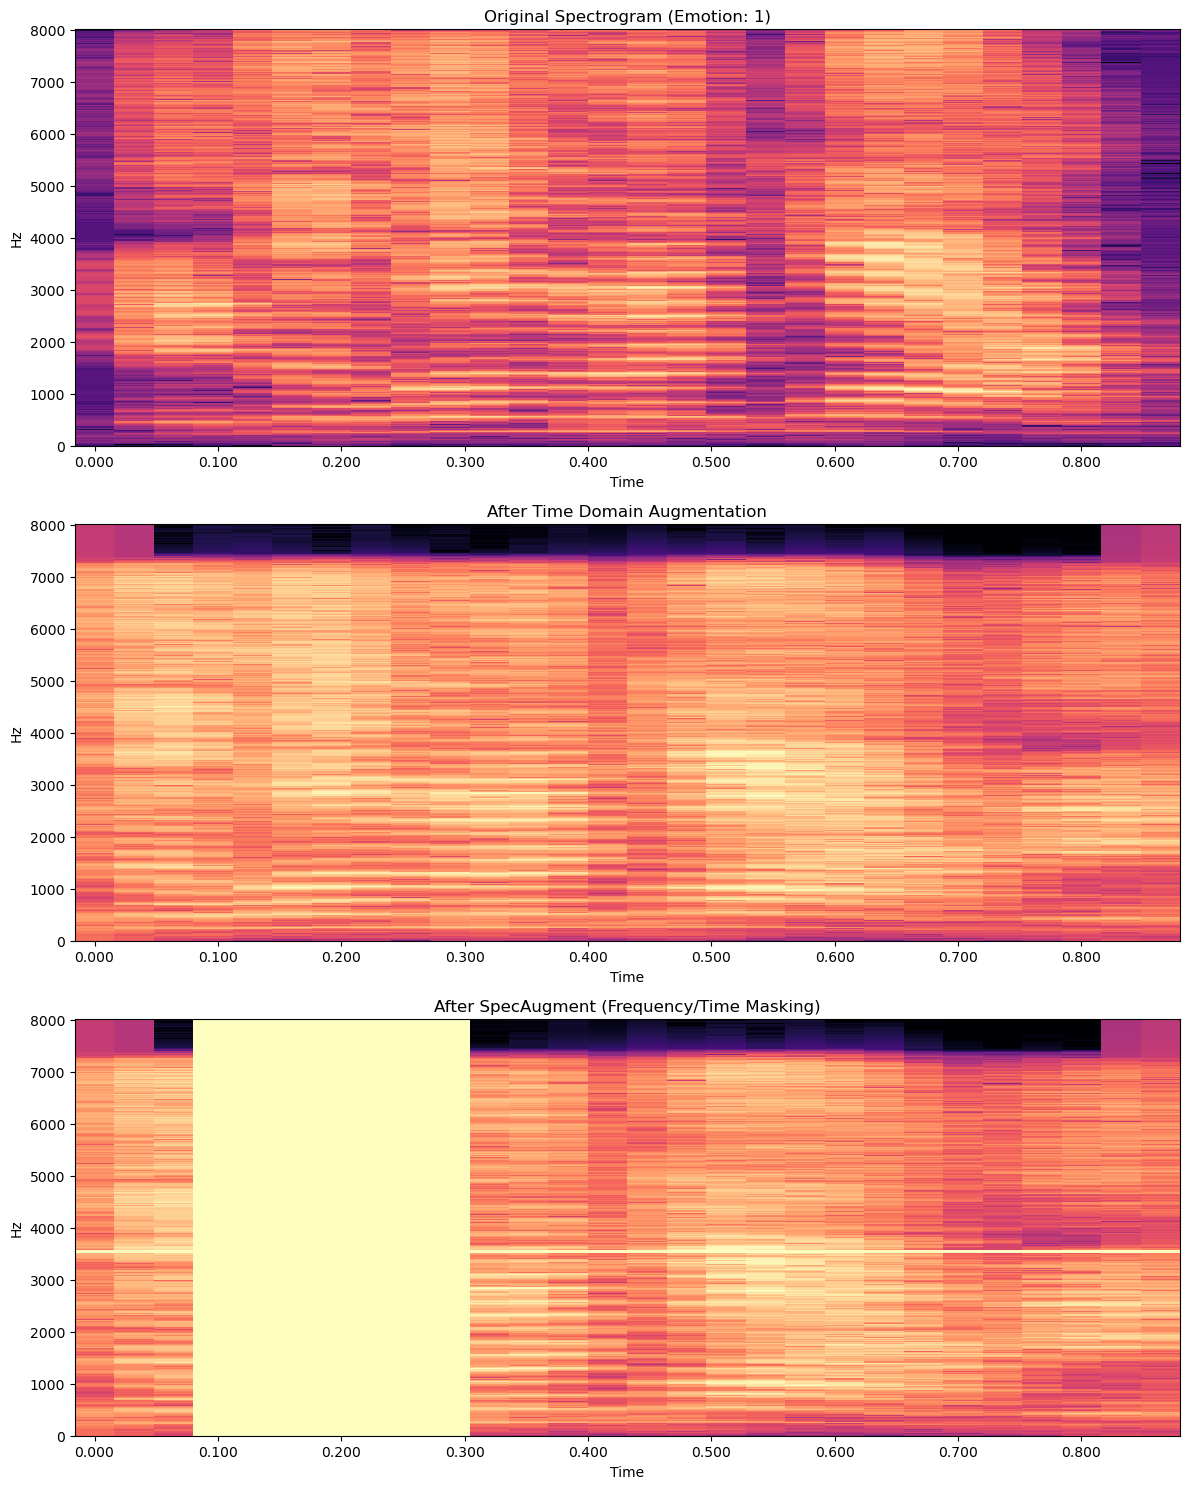

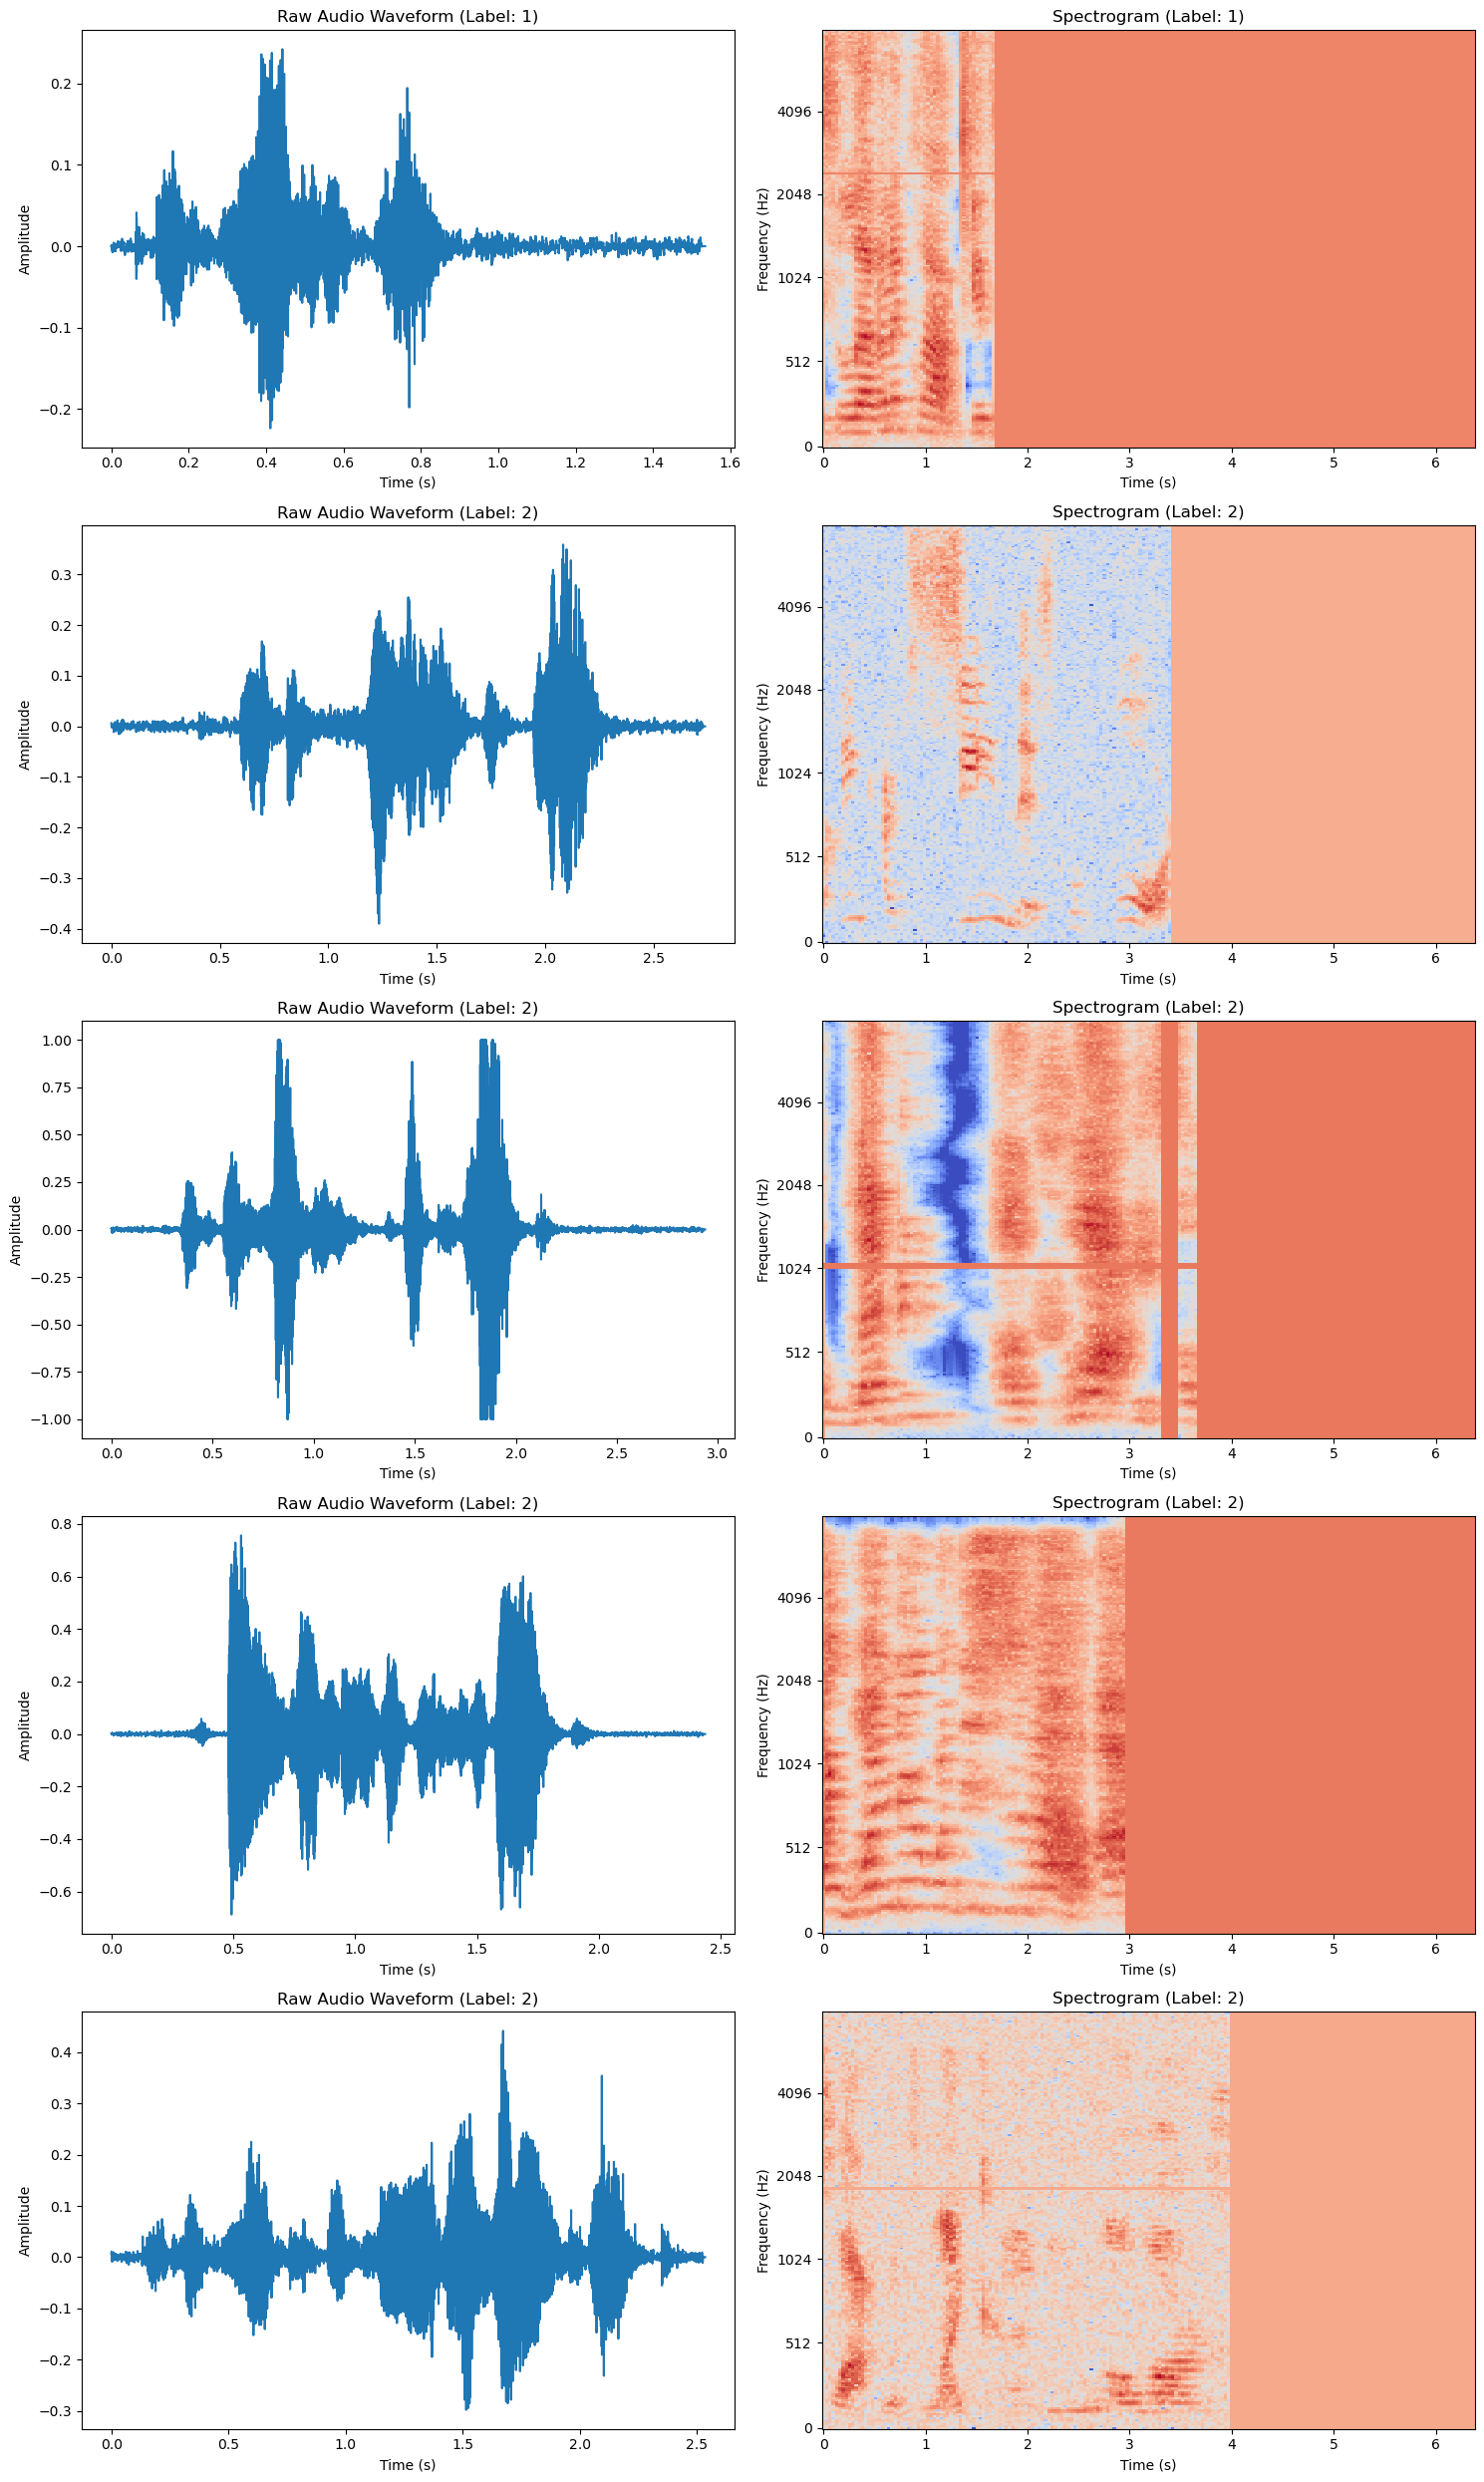

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import noisereduce as nr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import random
from scipy import signal


def extract_emotion_label(filename):
    parts = filename.split("_")
    emotion = parts[2]
    emotion_map = {"SAD": 0, "HAP": 1, "ANG": 2}
    return emotion_map.get(emotion, -1)

def preprocess_audio(audio_path, sr=16000):
    try:
        y, sr = librosa.load(audio_path, sr=sr)

        # Check if audio is empty or all zeros before normalizing
        if len(y) == 0 or np.max(np.abs(y)) == 0:
            print(f"Warning: Empty or silent audio detected: {audio_path}")
            return None, None

        y = y / np.max(np.abs(y))

        y = nr.reduce_noise(y=y, sr=sr)

        y, _ = librosa.effects.trim(y, top_db=20)

        # Check if trimming made the array empty
        if len(y) == 0:
            print(f"Warning: Audio became empty after trimming: {audio_path}")
            return None, None

        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        return y, sr
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None, None

# Data Augmentation
def time_shift(y, shift_range=0.2):
    shift = int(random.uniform(-shift_range, shift_range) * len(y))
    return np.roll(y, shift)

def pitch_shift(y, sr, n_steps=4):
    n_steps = random.uniform(-n_steps, n_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def time_stretch(y, rate_range=(0.8, 1.2)):
    rate = random.uniform(rate_range[0], rate_range[1])
    return librosa.effects.time_stretch(y, rate=rate)

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_signal = y + noise_factor * noise
    return augmented_signal

def random_gain(y, gain_range=(0.8, 1.2)):
    gain = random.uniform(gain_range[0], gain_range[1])
    return y * gain

def apply_augmentation(y, sr, augment_prob=0.5):
    augmentations = [
        (time_shift, {"shift_range": 0.2}),
        (pitch_shift, {"sr": sr, "n_steps": 2}),
        (time_stretch, {"rate_range": (0.85, 1.15)}),
        (add_noise, {"noise_factor": 0.005}),
        (random_gain, {"gain_range": (0.8, 1.2)})
    ]
    augmented_y = y.copy()
    for aug_func, aug_args in augmentations:
        if random.random() < augment_prob:
            augmented_y = aug_func(augmented_y, **aug_args)

    return augmented_y

#Spectogram extraction
def extract_spectrogram(audio_path, sr=16000, n_fft=512, hop_length=256, augment=False):
    y, sr = preprocess_audio(audio_path, sr=sr)

    if y is None:
        # This shouldn't happen as we've filtered out problematic files, but just in case
        raise ValueError(f"Failed to process audio: {audio_path}")

    # Apply augmentation if requested
    if augment:
        y = apply_augmentation(y, sr)

    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(spectrogram)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

# Spectrogram augmentation functions
def spec_augment(spectrogram, freq_mask_param=10, time_mask_param=10, num_masks=1):
    spec = spectrogram.clone()

    for i in range(num_masks):
        f_mask_width = random.randint(1, freq_mask_param)
        f_start = random.randint(0, spec.shape[1] - f_mask_width)
        spec[0, f_start:f_start + f_mask_width, :] = 0
    for i in range(num_masks):
        t_mask_width = random.randint(1, time_mask_param)
        t_start = random.randint(0, spec.shape[2] - t_mask_width)
        spec[0, :, t_start:t_start + t_mask_width] = 0

    return spec

# Function to pad or truncate spectrogram
def pad_or_truncate(spectrogram, target_height, target_width):
    _, height, width = spectrogram.shape

    if width > target_width:
        spectrogram = spectrogram[:, :, :target_width]
    elif width < target_width:
        pad_width = target_width - width
        spectrogram = F.pad(spectrogram, (0, pad_width), "constant", 0)

    if height > target_height:
        spectrogram = spectrogram[:, :target_height, :]
    elif height < target_height:
        pad_height = target_height - height
        spectrogram = F.pad(spectrogram, (0, 0, 0, pad_height), "constant", 0)

    return spectrogram

# Custom Dataset Class with Augmentation
class AudioDataset(Dataset):
    def __init__(self, folder_path, target_height=257, target_width=200, augment=False):
        self.folder_path = folder_path
        all_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

        # Filter out problematic files
        valid_files = []
        valid_labels = []

        for file in all_files:
            file_path = os.path.join(folder_path, file)
            y, sr = preprocess_audio(file_path)
            if y is not None:  # Only include files that processed successfully
                valid_files.append(file)
                valid_labels.append(extract_emotion_label(file))

        print(f"Kept {len(valid_files)} out of {len(all_files)} audio files")

        self.file_paths = [os.path.join(folder_path, f) for f in valid_files]
        self.labels = valid_labels
        self.target_height = target_height
        self.target_width = target_width
        self.augment = augment

        # Continue only if we have valid files
        if len(self.file_paths) == 0:
            raise ValueError("No valid audio files found in the dataset")

        all_spectrograms = []
        for file_path in self.file_paths:
            spectrogram = extract_spectrogram(file_path)
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
            spectrogram = pad_or_truncate(spectrogram, self.target_height, self.target_width)
            all_spectrograms.append(spectrogram)

        all_spectrograms = torch.stack(all_spectrograms)
        self.mean = all_spectrograms.mean()
        self.std = all_spectrograms.std()

        label_counts = Counter(self.labels)
        total_samples = sum(label_counts.values())
        self.class_weights = {label: total_samples / count for label, count in label_counts.items()}
        self.weights_tensor = torch.tensor([self.class_weights.get(i, 1.0) for i in range(len(self.class_weights))]).float()

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spectrogram = extract_spectrogram(self.file_paths[idx], augment=self.augment)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)

        spectrogram = (spectrogram - self.mean) / self.std

        spectrogram = pad_or_truncate(spectrogram, self.target_height, self.target_width)

        if self.augment and random.random() < 0.5:
            spectrogram = spec_augment(spectrogram)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return spectrogram, label

train_dataset = AudioDataset("NOT_BAD_PT2", augment=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = AudioDataset("NOT_BAD_PT2", augment=False)

criterion = torch.nn.CrossEntropyLoss(weight=train_dataset.weights_tensor.to("cuda" if torch.cuda.is_available() else "cpu"))

for spectrogram, label in train_loader:
    print("Spectrogram shape:", spectrogram.shape)
    print("Labels:", label)
    break

def visualize_augmentation(dataset, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(dataset))

    file_path = dataset.file_paths[idx]
    original_y, sr = preprocess_audio(file_path)

    augmented_y = apply_augmentation(original_y, sr)

    original_spec = librosa.stft(original_y)
    original_spec_db = librosa.power_to_db(np.abs(original_spec), ref=np.max)

    augmented_spec = librosa.stft(augmented_y)
    augmented_spec_db = librosa.power_to_db(np.abs(augmented_spec), ref=np.max)

    spec_aug_tensor = torch.tensor(augmented_spec_db, dtype=torch.float32).unsqueeze(0)
    spec_aug_tensor = spec_augment(+spec_aug_tensor)

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    librosa.display.specshow(original_spec_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[0])
    axes[0].set_title(f"Original Spectrogram (Emotion: {dataset.labels[idx]})")

    librosa.display.specshow(augmented_spec_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title("After Time Domain Augmentation")

    librosa.display.specshow(spec_aug_tensor.squeeze().numpy(), sr=sr, x_axis='time', y_axis='hz', ax=axes[2])
    axes[2].set_title("After SpecAugment (Frequency/Time Masking)")

    plt.tight_layout()
    plt.show()

visualize_augmentation(train_dataset)

# Visualize the samples
def visualize_audio_and_spectrograms(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        spectrogram, label = dataset[idx]

        y, sr = librosa.load(dataset.file_paths[idx], sr=16000)

        axes[i, 0].plot(np.arange(len(y)) / sr, y)
        axes[i, 0].set_title(f"Raw Audio Waveform (Label: {label.item()})")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Amplitude")

        librosa.display.specshow(spectrogram.squeeze().numpy(), sr=sr, x_axis='time', y_axis='mel', ax=axes[i, 1])
        axes[i, 1].set_title(f"Spectrogram (Label: {label.item()})")
        axes[i, 1].set_xlabel("Time (s)")
        axes[i, 1].set_ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

visualize_audio_and_spectrograms(train_dataset, num_samples=5)

# **Model Defination**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class EnhancedCNNFeatureExtractor(nn.Module):
    def __init__(self, input_dim=128):  # Increased dimension
        super().__init__()
        self.cnn = nn.Sequential(
            # Block 1 with residual connection
            nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(32),
            ),
            ChannelAttention(32),  # Added channel attention
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(64),
            ),
            ChannelAttention(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.BatchNorm2d(128),
            ),
            nn.AdaptiveAvgPool2d((1, 1)),  # Better for variable length
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128, input_dim),
            nn.Dropout(0.5)  # Increased dropout
        )

    def forward(self, x):
        x = self.cnn(x)
        return self.fc(x)

class TemporalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=0.2,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape: (batch, seq_len, features)
        attn_output, _ = self.multihead_attn(x, x, x)
        attn_output = self.dropout(attn_output)
        return self.layer_norm(x + attn_output)

class EnhancedTransformerEncoder(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, dim_feedforward):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, 101, input_dim))

        # Temporal attention before transformer
        self.temporal_attention = TemporalAttention(input_dim)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            activation='gelu',
            batch_first=True,
            dropout=0.2
        )
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers)

    def forward(self, x):
        # Add CLS token
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional encoding
        x = x + self.positional_encoding[:, :x.size(1)]

        # Apply temporal attention
        x = self.temporal_attention(x)

        # Transformer processing
        x = self.transformer(x)

        # Return only CLS token representation
        return x[:, 0]

class EnhancedHybridModel(nn.Module):
    def __init__(self, cnn_output_dim=128, num_heads=8, num_layers=4,
                 dim_feedforward=512, num_classes=7):
        super().__init__()
        self.cnn = EnhancedCNNFeatureExtractor(input_dim=cnn_output_dim)

        # Additional temporal processing branch
        self.temporal_branch = nn.Sequential(
            nn.Linear(cnn_output_dim, cnn_output_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            TemporalAttention(cnn_output_dim)
        )

        self.transformer = EnhancedTransformerEncoder(
            cnn_output_dim,
            num_heads,
            num_layers,
            dim_feedforward
        )

        # Enhanced classifier
        self.classifier = nn.Sequential(
            nn.Linear(cnn_output_dim * 2, cnn_output_dim),  # *2 for both branches
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(cnn_output_dim, num_classes)
        )

    def forward(self, x):
        # CNN feature extraction
        cnn_features = self.cnn(x)

        # Prepare for temporal processing (batch, seq_len, features)
        # Assuming your input has temporal dimension
        batch_size = x.size(0)
        cnn_features = cnn_features.view(batch_size, -1, cnn_features.size(-1))

        # Main transformer branch
        transformer_features = self.transformer(cnn_features)

        # Parallel temporal attention branch
        temporal_features = self.temporal_branch(cnn_features)
        temporal_features = temporal_features.mean(dim=1)  # Pool temporal dimension

        # Combine both branches
        combined_features = torch.cat([transformer_features, temporal_features], dim=1)

        # Classification
        return self.classifier(combined_features)

c:\Users\maahi\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [5]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.Collecting torchviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00


# **Model Initialization and Training**

Epoch 1, Loss: 1.0164, Accuracy: 42.55%


Epoch 2, Loss: 0.9248, Accuracy: 49.97%


Epoch 3, Loss: 0.8948, Accuracy: 53.17%


Epoch 4, Loss: 0.8654, Accuracy: 54.70%


Epoch 5, Loss: 0.8226, Accuracy: 58.18%


Epoch 6, Loss: 0.7841, Accuracy: 61.75%


Epoch 7, Loss: 0.7833, Accuracy: 62.85%


Epoch 8, Loss: 0.7479, Accuracy: 64.98%


Epoch 9, Loss: 0.7417, Accuracy: 65.90%


Epoch 10, Loss: 0.7078, Accuracy: 67.47%


Epoch 11, Loss: 0.7200, Accuracy: 67.50%


Epoch 12, Loss: 0.7014, Accuracy: 68.31%


Epoch 13, Loss: 0.7058, Accuracy: 68.31%


Epoch 14, Loss: 0.6883, Accuracy: 69.44%


Epoch 15, Loss: 0.6635, Accuracy: 69.86%


Epoch 16, Loss: 0.6829, Accuracy: 69.44%


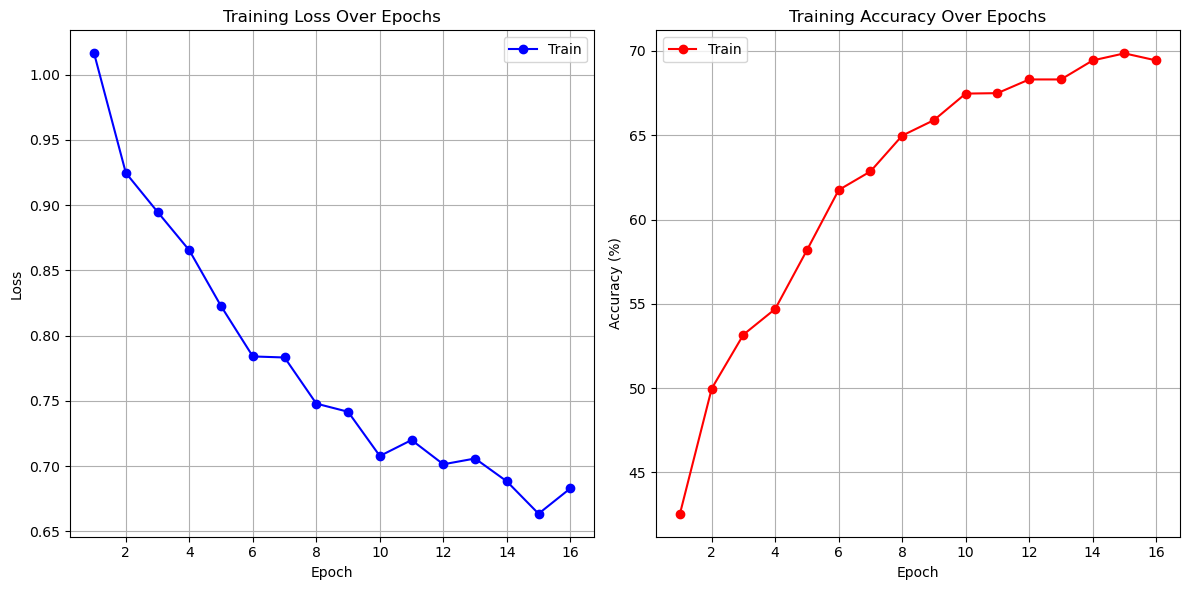

In [18]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Create dataset and dataloader
dataset = train_dataset


# Initialize the enhanced model
model = EnhancedHybridModel(
    cnn_output_dim=128,  # Increased from 64
    num_heads=8,         # Increased from 4
    num_layers=4,        # Increased from 2
    dim_feedforward=512, # Increased from 256
    num_classes=3
)

# Adjust class weights based on your dataset
class_weights = torch.tensor([1.0, 2.0, 1.0]).float()  # Make sure these match your class distribution
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Enhanced optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(),
                             lr=3e-4,
                             weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Training tracking
epoch_losses = []
epoch_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(16):  # Number of epochs
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/16", leave=False)

    for spectrogram, label in progress_bar:
        # Forward pass
        outputs = model(spectrogram)
        loss = criterion(outputs, label)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == label).sum().item()
        epoch_total += label.size(0)
        accuracy = 100 * epoch_correct / epoch_total

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            loss=loss.item(),
            accuracy=f"{accuracy:.2f}%",
            lr=optimizer.param_groups[0]['lr']
        )

    # Update learning rate
    scheduler.step()

    # Calculate epoch metrics
    epoch_loss /= len(train_loader)
    epoch_accuracy = 100 * epoch_correct / epoch_total
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation phase (add your validation code here if available)
    # model.eval()
    # ... validation code ...
    # val_losses.append(val_loss)
    # val_accuracies.append(val_accuracy)

# Plot training curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', linestyle='-', color='b', label='Train')
# plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', linestyle='-', color='orange', label='Val')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_accuracies)+1), epoch_accuracies, marker='o', linestyle='-', color='r', label='Train')
# plt.plot(range(1, len(val_accuracies)+1), val_accuracies, marker='o', linestyle='-', color='green', label='Val')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Test Batch Accuracy**

In [19]:
test_folder_path = "NOT BAD"
test_dataset = AudioDataset(test_folder_path)

Kept 216 out of 216 audio files


In [20]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [21]:
for spectrogram, label in test_loader:
    print("Spectrogram shape:", spectrogram.shape)
    print("Labels:", label)
    break

Spectrogram shape: torch.Size([8, 1, 257, 200])
Labels: tensor([2, 1, 0, 2, 1, 0, 2, 1])


Test Accuracy: 52.31%
Precision: 0.5419
Recall: 0.5231
F1-Score: 0.4623
[[57 11  4]
 [22 49  1]
 [20 45  7]]


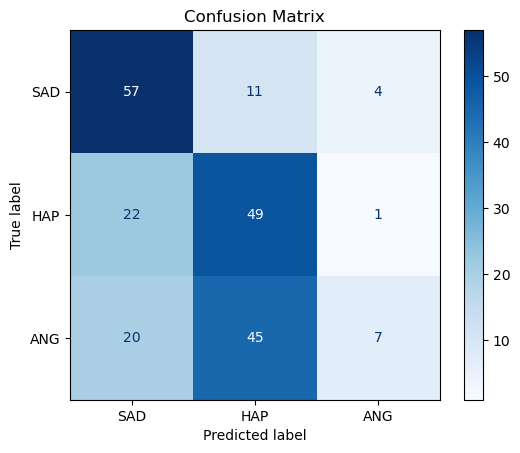

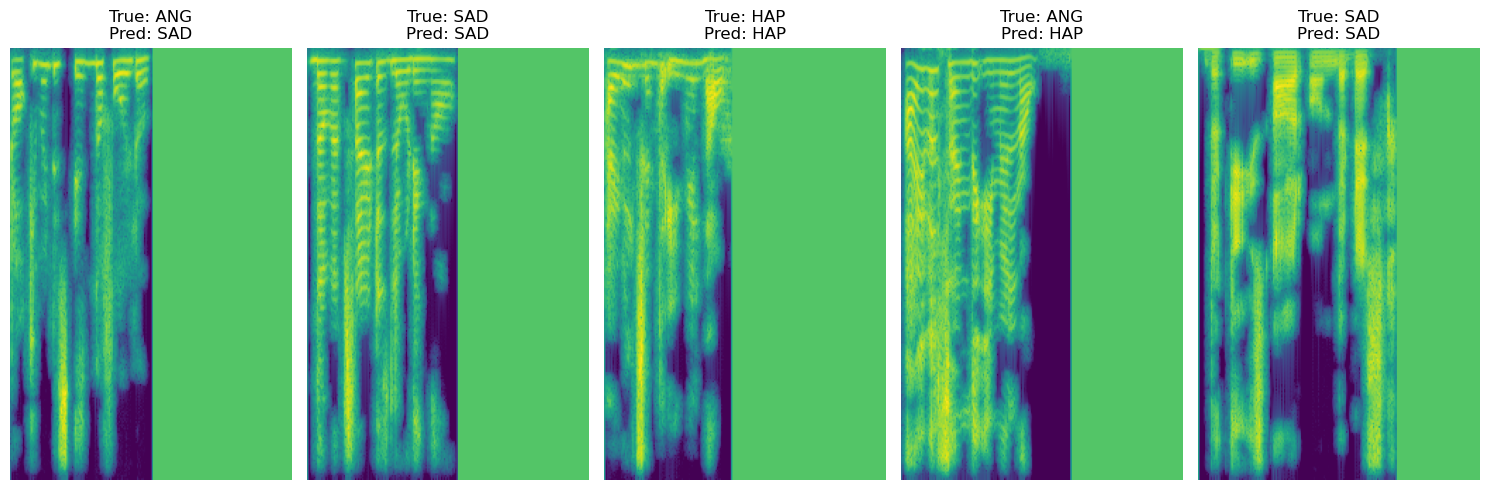

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for spectrogram, label in test_loader:
        # Forward pass
        outputs = model(spectrogram)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)
emotion_map = {0: "SAD", 1: "HAP", 2: "ANG"}
class_names = [emotion_map[i] for i in range(len(emotion_map))]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer display
plt.title("Confusion Matrix")
plt.show()

import torch
import matplotlib.pyplot as plt

def plot_predictions(test_loader, model, num_samples=5):
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    with torch.no_grad():
        for i, (spectrogram, label) in enumerate(test_loader):
            if i >= num_samples:
                break

            output = model(spectrogram)
            _, pred = torch.max(output, 1)

            spectrogram = spectrogram.squeeze().cpu().numpy()
            spectrogram = spectrogram[0]
            true_label = label[0].item()
            pred_label = pred[0].item()

            axes[i].imshow(spectrogram, cmap='viridis', aspect='auto')
            axes[i].set_title(f"True: {emotion_map[true_label]}\nPred: {emotion_map[pred_label]}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(test_loader, model, num_samples=5)

# **Saving the Model**

In [24]:
import torch
import os
from datetime import datetime

# Create a directory for saved models if it doesn't exist
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# Create a filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"speech_emotion_model_{timestamp}.pth"
save_path = os.path.join(save_dir, model_name)

# Save the model (complete version)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss,
    'accuracy': accuracy,
    'model_params': {
        'cnn_output_dim': 128,
        'num_heads': 8,
        'num_layers': 4, 
        'dim_feedforward': 512,
        'num_classes': 3
    }
}, save_path)

print(f"Model successfully saved to {save_path}")

Model successfully saved to ./saved_models\speech_emotion_model_20250417_215939.pth


In [13]:
# 1. First initialize your model architecture
loaded_model = EnhancedHybridModel(
    cnn_output_dim=128,
    num_heads=8,
    num_layers=4,
    dim_feedforward=512,
    num_classes=3
)

# 2. Initialize your optimizer (must match original training setup)
optimizer = torch.optim.AdamW(
    loaded_model.parameters(),
    lr=3e-4,  # Default learning rate, will be overwritten by checkpoint
    weight_decay=1e-4
)

# 3. Now load the checkpoint
checkpoint = torch.load("saved_models\speech_emotion_model_20250417_215939.pth")

# 4. Load the states
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 5. Access other saved information
epoch = checkpoint['epoch']
loss = checkpoint['loss']
accuracy = checkpoint['accuracy']

print(f"Loaded model from epoch {epoch} with accuracy {accuracy:.2f}%")

Loaded model from epoch 15 with accuracy 0.52%


c:\Users\maahi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Kept 197 out of 197 audio files
Kept 49 out of 49 audio files
Spectrogram shape: torch.Size([8, 1, 257, 200])
Labels: tensor([2, 1, 2, 1, 2, 2, 1, 0])


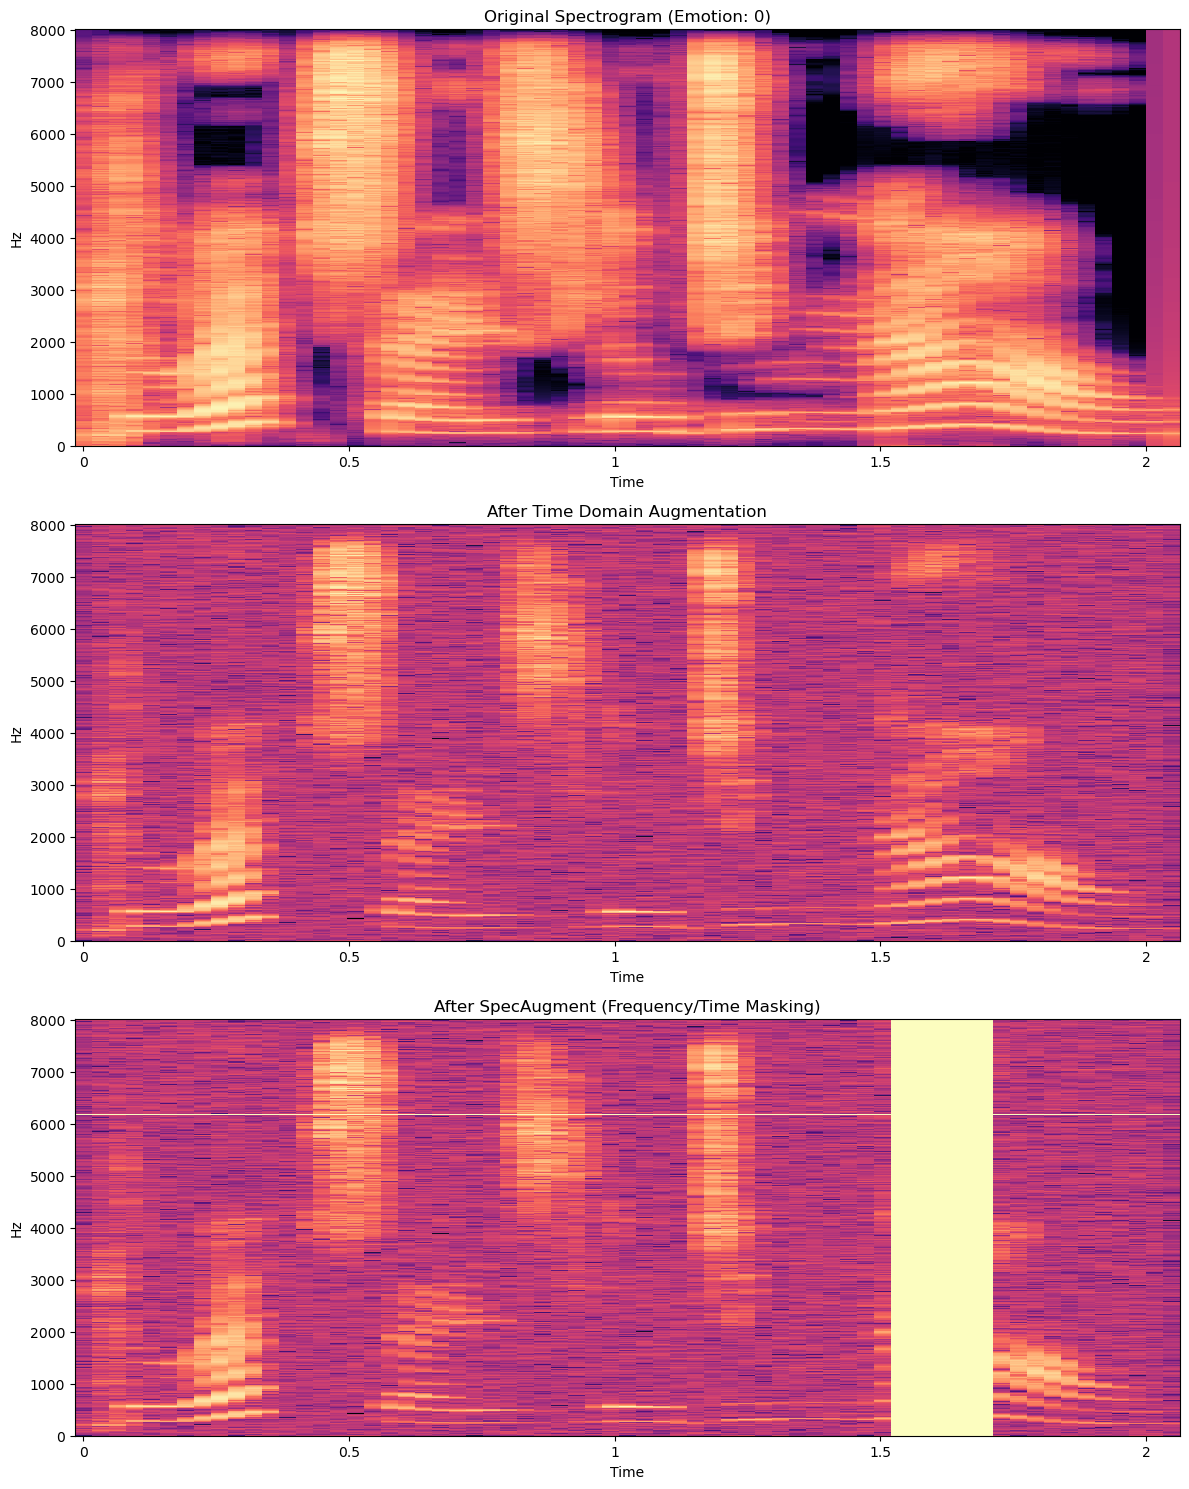

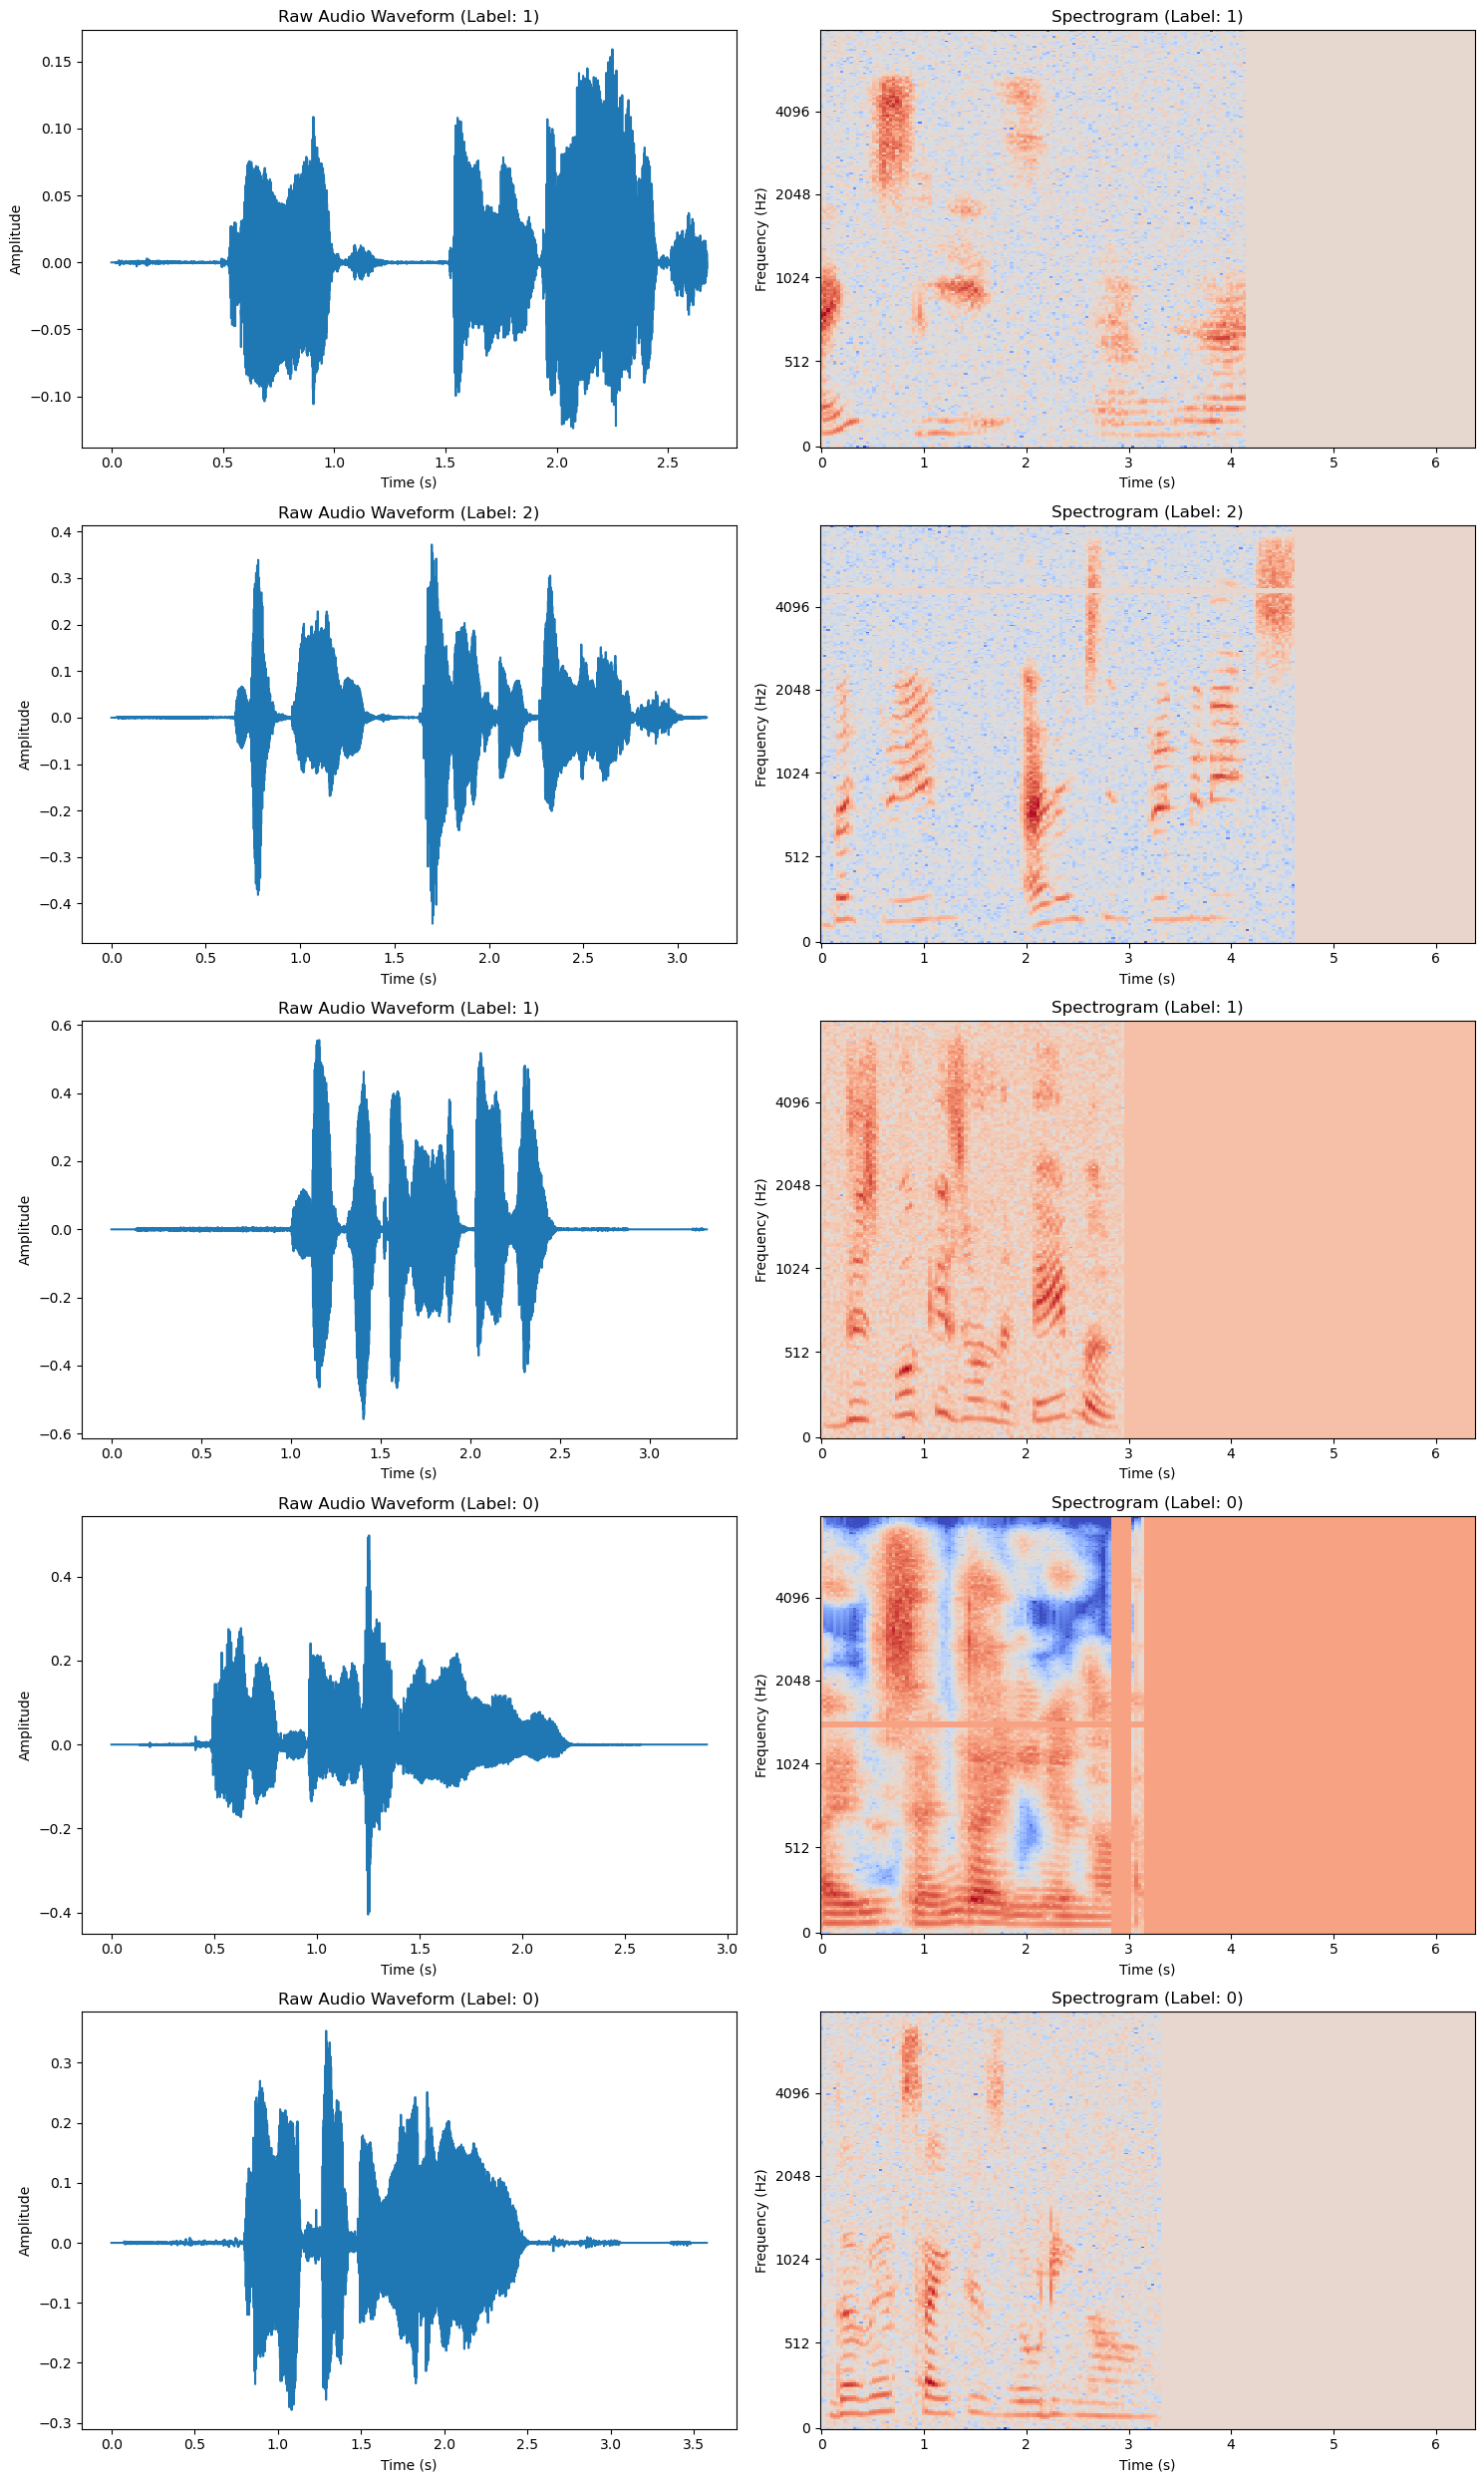

In [11]:
import os
import librosa
import librosa.display
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import noisereduce as nr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import random
from scipy import signal


def extract_emotion_label(filename):
    parts = filename.split("_")
    emotion = parts[2]
    emotion_map = {"SAD": 0, "HAP": 1, "ANG": 2}
    return emotion_map.get(emotion, -1)

def preprocess_audio(audio_path, sr=16000):
    try:
        y, sr = librosa.load(audio_path, sr=sr)

        # Check if audio is empty or all zeros before normalizing
        if len(y) == 0 or np.max(np.abs(y)) == 0:
            print(f"Warning: Empty or silent audio detected: {audio_path}")
            return None, None

        y = y / np.max(np.abs(y))

        y = nr.reduce_noise(y=y, sr=sr)

        y, _ = librosa.effects.trim(y, top_db=20)

        # Check if trimming made the array empty
        if len(y) == 0:
            print(f"Warning: Audio became empty after trimming: {audio_path}")
            return None, None

        pre_emphasis = 0.97
        y = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

        return y, sr
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None, None

# Data Augmentation
def time_shift(y, shift_range=0.2):
    shift = int(random.uniform(-shift_range, shift_range) * len(y))
    return np.roll(y, shift)

def pitch_shift(y, sr, n_steps=4):
    n_steps = random.uniform(-n_steps, n_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def time_stretch(y, rate_range=(0.8, 1.2)):
    rate = random.uniform(rate_range[0], rate_range[1])
    return librosa.effects.time_stretch(y, rate=rate)

def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_signal = y + noise_factor * noise
    return augmented_signal

def random_gain(y, gain_range=(0.8, 1.2)):
    gain = random.uniform(gain_range[0], gain_range[1])
    return y * gain

def apply_augmentation(y, sr, augment_prob=0.5):
    augmentations = [
        (time_shift, {"shift_range": 0.2}),
        (pitch_shift, {"sr": sr, "n_steps": 2}),
        (time_stretch, {"rate_range": (0.85, 1.15)}),
        (add_noise, {"noise_factor": 0.005}),
        (random_gain, {"gain_range": (0.8, 1.2)})
    ]
    augmented_y = y.copy()
    for aug_func, aug_args in augmentations:
        if random.random() < augment_prob:
            augmented_y = aug_func(augmented_y, **aug_args)

    return augmented_y

#Spectogram extraction
def extract_spectrogram(audio_path, sr=16000, n_fft=512, hop_length=256, augment=False):
    y, sr = preprocess_audio(audio_path, sr=sr)

    if y is None:
        # This shouldn't happen as we've filtered out problematic files, but just in case
        raise ValueError(f"Failed to process audio: {audio_path}")

    # Apply augmentation if requested
    if augment:
        y = apply_augmentation(y, sr)

    spectrogram = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(spectrogram)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram

# Spectrogram augmentation functions
def spec_augment(spectrogram, freq_mask_param=10, time_mask_param=10, num_masks=1):
    spec = spectrogram.clone()

    for i in range(num_masks):
        f_mask_width = random.randint(1, freq_mask_param)
        f_start = random.randint(0, spec.shape[1] - f_mask_width)
        spec[0, f_start:f_start + f_mask_width, :] = 0
    for i in range(num_masks):
        t_mask_width = random.randint(1, time_mask_param)
        t_start = random.randint(0, spec.shape[2] - t_mask_width)
        spec[0, :, t_start:t_start + t_mask_width] = 0

    return spec

# Function to pad or truncate spectrogram
def pad_or_truncate(spectrogram, target_height, target_width):
    _, height, width = spectrogram.shape

    if width > target_width:
        spectrogram = spectrogram[:, :, :target_width]
    elif width < target_width:
        pad_width = target_width - width
        spectrogram = F.pad(spectrogram, (0, pad_width), "constant", 0)

    if height > target_height:
        spectrogram = spectrogram[:, :target_height, :]
    elif height < target_height:
        pad_height = target_height - height
        spectrogram = F.pad(spectrogram, (0, 0, 0, pad_height), "constant", 0)

    return spectrogram

# Custom Dataset Class with Augmentation
class AudioDataset(Dataset):
    def __init__(self, folder_path, target_height=257, target_width=200, augment=False):
        self.folder_path = folder_path
        all_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

        # Filter out problematic files
        valid_files = []
        valid_labels = []

        for file in all_files:
            file_path = os.path.join(folder_path, file)
            y, sr = preprocess_audio(file_path)
            if y is not None:  # Only include files that processed successfully
                valid_files.append(file)
                valid_labels.append(extract_emotion_label(file))

        print(f"Kept {len(valid_files)} out of {len(all_files)} audio files")

        self.file_paths = [os.path.join(folder_path, f) for f in valid_files]
        self.labels = valid_labels
        self.target_height = target_height
        self.target_width = target_width
        self.augment = augment

        # Continue only if we have valid files
        if len(self.file_paths) == 0:
            raise ValueError("No valid audio files found in the dataset")

        all_spectrograms = []
        for file_path in self.file_paths:
            spectrogram = extract_spectrogram(file_path)
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
            spectrogram = pad_or_truncate(spectrogram, self.target_height, self.target_width)
            all_spectrograms.append(spectrogram)

        all_spectrograms = torch.stack(all_spectrograms)
        self.mean = all_spectrograms.mean()
        self.std = all_spectrograms.std()

        label_counts = Counter(self.labels)
        total_samples = sum(label_counts.values())
        self.class_weights = {label: total_samples / count for label, count in label_counts.items()}
        self.weights_tensor = torch.tensor([self.class_weights.get(i, 1.0) for i in range(len(self.class_weights))]).float()

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spectrogram = extract_spectrogram(self.file_paths[idx], augment=self.augment)
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)

        spectrogram = (spectrogram - self.mean) / self.std

        spectrogram = pad_or_truncate(spectrogram, self.target_height, self.target_width)

        if self.augment and random.random() < 0.5:
            spectrogram = spec_augment(spectrogram)

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return spectrogram, label

train_dataset = AudioDataset("train", augment=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = AudioDataset("test", augment=False)

criterion = torch.nn.CrossEntropyLoss(weight=train_dataset.weights_tensor.to("cuda" if torch.cuda.is_available() else "cpu"))

for spectrogram, label in train_loader:
    print("Spectrogram shape:", spectrogram.shape)
    print("Labels:", label)
    break

def visualize_augmentation(dataset, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(dataset))

    file_path = dataset.file_paths[idx]
    original_y, sr = preprocess_audio(file_path)

    augmented_y = apply_augmentation(original_y, sr)

    original_spec = librosa.stft(original_y)
    original_spec_db = librosa.power_to_db(np.abs(original_spec), ref=np.max)

    augmented_spec = librosa.stft(augmented_y)
    augmented_spec_db = librosa.power_to_db(np.abs(augmented_spec), ref=np.max)

    spec_aug_tensor = torch.tensor(augmented_spec_db, dtype=torch.float32).unsqueeze(0)
    spec_aug_tensor = spec_augment(+spec_aug_tensor)

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    librosa.display.specshow(original_spec_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[0])
    axes[0].set_title(f"Original Spectrogram (Emotion: {dataset.labels[idx]})")

    librosa.display.specshow(augmented_spec_db, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title("After Time Domain Augmentation")

    librosa.display.specshow(spec_aug_tensor.squeeze().numpy(), sr=sr, x_axis='time', y_axis='hz', ax=axes[2])
    axes[2].set_title("After SpecAugment (Frequency/Time Masking)")

    plt.tight_layout()
    plt.show()

visualize_augmentation(train_dataset)

# Visualize the samples
def visualize_audio_and_spectrograms(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        spectrogram, label = dataset[idx]

        y, sr = librosa.load(dataset.file_paths[idx], sr=16000)

        axes[i, 0].plot(np.arange(len(y)) / sr, y)
        axes[i, 0].set_title(f"Raw Audio Waveform (Label: {label.item()})")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Amplitude")

        librosa.display.specshow(spectrogram.squeeze().numpy(), sr=sr, x_axis='time', y_axis='mel', ax=axes[i, 1])
        axes[i, 1].set_title(f"Spectrogram (Label: {label.item()})")
        axes[i, 1].set_xlabel("Time (s)")
        axes[i, 1].set_ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

visualize_audio_and_spectrograms(train_dataset, num_samples=5)

In [41]:
# Assuming class indices: 0=sad, 1=happy, 2=angry
class_weights = torch.tensor([1.0, 1.5, 2.5])  # Adjust these values as needed
class_weights = class_weights.to(device)  # Move to GPU if available

# Update your criterion
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [42]:
epoch_losses = []
epoch_accuracies = []
val_losses = []
val_accuracies = []

# Class-specific counters
class_correct = [0, 0, 0]  # sad, happy, angry
class_total = [0, 0, 0]

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

for epoch in range(10):
    loaded_model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    # Reset class counters
    class_correct = [0, 0, 0]
    class_total = [0, 0, 0]

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/10", leave=False)

    for spectrogram, label in progress_bar:
        spectrogram, label = spectrogram.to(device), label.to(device)
        
        # Forward pass
        outputs = loaded_model(spectrogram)
        loss = criterion(outputs, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(loaded_model.parameters(), max_norm=1.0)
        optimizer.step()

        # Metrics
        _, predicted = torch.max(outputs, 1)
        epoch_correct += (predicted == label).sum().item()
        epoch_total += label.size(0)
        epoch_loss += loss.item()

        # Class-specific metrics
        for i in range(3):  # For each class
            mask = (label == i)
            class_correct[i] += (predicted[mask] == label[mask]).sum().item()
            class_total[i] += mask.sum().item()

        progress_bar.set_postfix(
            loss=loss.item(),
            acc=f"{100*epoch_correct/epoch_total:.2f}%",
            angry_acc=f"{100*class_correct[2]/max(1,class_total[2]):.2f}%" if class_total[2] > 0 else "N/A"
        )

    # Epoch statistics
    epoch_loss /= len(train_loader)
    epoch_accuracy = 100 * epoch_correct / epoch_total
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    
    # Print class-wise accuracy
    print(f"\nEpoch {epoch+1} Class Accuracies:")
    print(f"  Sad (0): {100*class_correct[0]/max(1,class_total[0]):.2f}%")
    print(f"Happy (1): {100*class_correct[1]/max(1,class_total[1]):.2f}%")
    print(f"Angry (2): {100*class_correct[2]/max(1,class_total[2]):.2f}%")


Epoch 1 Class Accuracies:
  Sad (0): 66.18%
Happy (1): 58.73%
Angry (2): 36.36%



Epoch 2 Class Accuracies:
  Sad (0): 64.71%
Happy (1): 57.14%
Angry (2): 40.91%



Epoch 3 Class Accuracies:
  Sad (0): 54.41%
Happy (1): 55.56%
Angry (2): 36.36%



Epoch 4 Class Accuracies:
  Sad (0): 67.65%
Happy (1): 60.32%
Angry (2): 46.97%



Epoch 5 Class Accuracies:
  Sad (0): 66.18%
Happy (1): 63.49%
Angry (2): 57.58%



Epoch 6 Class Accuracies:
  Sad (0): 63.24%
Happy (1): 55.56%
Angry (2): 46.97%



Epoch 7 Class Accuracies:
  Sad (0): 60.29%
Happy (1): 53.97%
Angry (2): 40.91%



Epoch 8 Class Accuracies:
  Sad (0): 64.71%
Happy (1): 52.38%
Angry (2): 45.45%



Epoch 9 Class Accuracies:
  Sad (0): 54.41%
Happy (1): 53.97%
Angry (2): 43.94%



Epoch 10 Class Accuracies:
  Sad (0): 69.12%
Happy (1): 63.49%
Angry (2): 42.42%


In [43]:
test_folder_path = "test"
test_dataset = AudioDataset(test_folder_path)

Kept 49 out of 49 audio files


In [44]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [45]:
for spectrogram, label in test_loader:
    print("Spectrogram shape:", spectrogram.shape)
    print("Labels:", label)
    break

Spectrogram shape: torch.Size([8, 1, 257, 200])
Labels: tensor([0, 0, 2, 2, 0, 0, 1, 1])


Test Accuracy: 63.27%
Precision: 0.6587
Recall: 0.6327
F1-Score: 0.6388
[[13  4  3]
 [ 2  8  2]
 [ 2  5 10]]


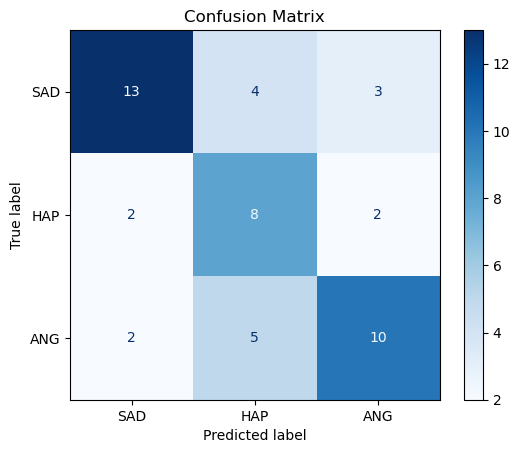

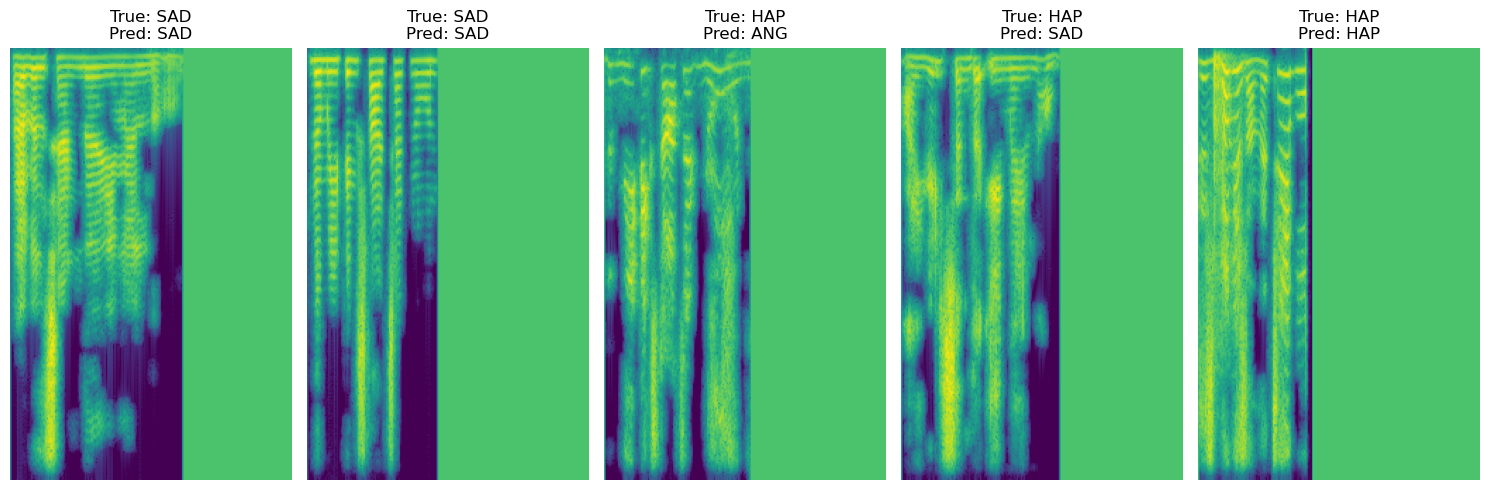

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
loaded_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for spectrogram, label in test_loader:
        # Forward pass
        outputs = loaded_model(spectrogram)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)
emotion_map = {0: "SAD", 1: "HAP", 2: "ANG"}
class_names = [emotion_map[i] for i in range(len(emotion_map))]

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 'd' for integer display
plt.title("Confusion Matrix")
plt.show()

import torch
import matplotlib.pyplot as plt

def plot_predictions(test_loader, model, num_samples=5):
    model.eval()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    with torch.no_grad():
        for i, (spectrogram, label) in enumerate(test_loader):
            if i >= num_samples:
                break

            output = model(spectrogram)
            _, pred = torch.max(output, 1)

            spectrogram = spectrogram.squeeze().cpu().numpy()
            spectrogram = spectrogram[0]
            true_label = label[0].item()
            pred_label = pred[0].item()

            axes[i].imshow(spectrogram, cmap='viridis', aspect='auto')
            axes[i].set_title(f"True: {emotion_map[true_label]}\nPred: {emotion_map[pred_label]}")
            axes[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(test_loader, loaded_model, num_samples=5)